## 0. Init

In [6]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

sys.path.append("../../")

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from choice_learn.basket_models.self_attention_model import SelfAttentionModel


In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


## I.  Synthetic Dataset

Dataset We build a synthetic dataset for which the catalog has 8 items, I=
{1,...,8}, with the following interactions:
- Cannibalization: {0,1, 2} on the one hand and {3,4,5} on the other hand
form groups of items cannibalizing each other.
- Complementarity: each of the items in {0,1,2} are complementary to each
of the items in {3,4,5};
- Neutral: 6, 7 and 8 are neutral in the sense that they don’t have specific
interaction with other items.
- When choosing among the first nest, user 0 prefers item 0, user 1 the item 1 and user 2 the item 2.

In [9]:
from choice_learn.basket_models.datasets.synthetic_dataset import SyntheticDataGenerator

"""items_nest : dict
                Dictionary defining item sets and their relations.
                Key should be next index and values list of items indexes, e.g."""

items_nest = { 0:[0, 1,2],
                1: [3,4,5],
                2: [6,7,8]}

"""nests_interactions: list
                List of interactions between nests for each nest. Symmetry should
                be ensure by users, e.g."""
                
nests_interactions = [["", "compl", "neutral", "neutral"],
                    ["compl", "", "neutral", "neutral"],
                    ["neutral", "neutral", "", "neutral"]]
    
""" proba_complementary_items : float
        Probability of adding complementary items to the basket.
    proba_neutral_items : float
        Probability of adding neutral items to the basket.
    noise_proba : float
        Probability of adding noise items to the basket."""

user_profile = {0:{ "nest" : 0, "item" : 0}, 1: {"nest" : 0, "item" : 1}, 2: {"nest" : 0, "item" : 2}}

"""user_profile : dict
                Dictionary defining user profiles.
                Key should be user index and values a dict with 'nest' and 'item' keys"""

data = SyntheticDataGenerator(items_nest=items_nest,
                       nests_interactions=nests_interactions,
                       proba_complementary_items=1,
                       proba_neutral_items=0.0,
                       noise_proba=0.0,
                       user_profile=user_profile
                        )

data = data.generate_trip_dataset(n_baskets=1000, assortments_matrix=np.ones((1, 9)))

data.available_items

array([[1., 1., 1., 1., 1., 1., 1., 1., 1.]])

## II. Self Attention Model

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

lr = 0.005
n_epochs = 20
batch_size = 32
latent_sizes = {"short_term": 2, "long_term": 2}
L = 7
hinge_margin = 0.7
short_term_ratio = 0.3
n_negative_samples = 1
optimizer = "adam"
λ = 0.0
dropout_rate = 0.0



In [14]:
model = SelfAttentionModel(
    optimizer=optimizer,
    n_negative_samples=n_negative_samples,
    lr=lr,
    epochs=n_epochs,
    batch_size=batch_size,
    latent_sizes=latent_sizes,
    hinge_margin=hinge_margin,
    short_term_ratio=short_term_ratio,
    l2_regularization=λ,
    dropout_rate=dropout_rate,
   
)

model.instantiate(n_items=data.n_items, n_users=data.n_users)

In [15]:
history = model.fit(trip_dataset=data, verbose=2)

Epoch 0 Train Loss 0.9838:   5%|▌         | 1/20 [00:04<01:19,  4.19s/it]

Loop 0 Time: 4.1906 Loss: 0.9838


Epoch 1 Train Loss 0.7721:  10%|█         | 2/20 [00:04<00:34,  1.91s/it]

Loop 1 Time: 0.3132 Loss: 0.7721


Epoch 2 Train Loss 0.5053:  15%|█▌        | 3/20 [00:04<00:20,  1.21s/it]

Loop 2 Time: 0.3666 Loss: 0.5053


Epoch 3 Train Loss 0.4098:  20%|██        | 4/20 [00:05<00:14,  1.14it/s]

Loop 3 Time: 0.3685 Loss: 0.4098


Epoch 4 Train Loss 0.3671:  25%|██▌       | 5/20 [00:05<00:10,  1.44it/s]

Loop 4 Time: 0.3717 Loss: 0.3671


Epoch 5 Train Loss 0.3582:  30%|███       | 6/20 [00:05<00:08,  1.71it/s]

Loop 5 Time: 0.3716 Loss: 0.3582


Epoch 6 Train Loss 0.3598:  35%|███▌      | 7/20 [00:06<00:06,  1.93it/s]

Loop 6 Time: 0.3727 Loss: 0.3598


Epoch 7 Train Loss 0.3470:  40%|████      | 8/20 [00:06<00:05,  2.11it/s]

Loop 7 Time: 0.3772 Loss: 0.3470


Epoch 8 Train Loss 0.3636:  45%|████▌     | 9/20 [00:07<00:04,  2.24it/s]

Loop 8 Time: 0.3835 Loss: 0.3636


Epoch 9 Train Loss 0.3579:  50%|█████     | 10/20 [00:07<00:04,  2.33it/s]

Loop 9 Time: 0.3881 Loss: 0.3579


Epoch 10 Train Loss 0.3726:  55%|█████▌    | 11/20 [00:07<00:03,  2.42it/s]

Loop 10 Time: 0.3763 Loss: 0.3726


Epoch 11 Train Loss 0.3679:  60%|██████    | 12/20 [00:08<00:03,  2.50it/s]

Loop 11 Time: 0.3637 Loss: 0.3679


Epoch 12 Train Loss 0.3637:  65%|██████▌   | 13/20 [00:08<00:02,  2.55it/s]

Loop 12 Time: 0.3743 Loss: 0.3637


Epoch 13 Train Loss 0.3472:  70%|███████   | 14/20 [00:09<00:02,  2.58it/s]

Loop 13 Time: 0.3724 Loss: 0.3472


Epoch 14 Train Loss 0.3624:  75%|███████▌  | 15/20 [00:09<00:01,  2.60it/s]

Loop 14 Time: 0.3748 Loss: 0.3624


Epoch 15 Train Loss 0.3542:  80%|████████  | 16/20 [00:09<00:01,  2.63it/s]

Loop 15 Time: 0.3701 Loss: 0.3542


Epoch 16 Train Loss 0.3462:  85%|████████▌ | 17/20 [00:10<00:01,  2.71it/s]

Loop 16 Time: 0.3401 Loss: 0.3462


Epoch 17 Train Loss 0.3698:  90%|█████████ | 18/20 [00:10<00:00,  2.71it/s]

Loop 17 Time: 0.3663 Loss: 0.3698


Epoch 18 Train Loss 0.3460:  95%|█████████▌| 19/20 [00:10<00:00,  2.85it/s]

Loop 18 Time: 0.3073 Loss: 0.3460


Epoch 19 Train Loss 0.3779: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]

Loop 19 Time: 0.3528 Loss: 0.3779


/tmp/ipykernel_2573140/947846572.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


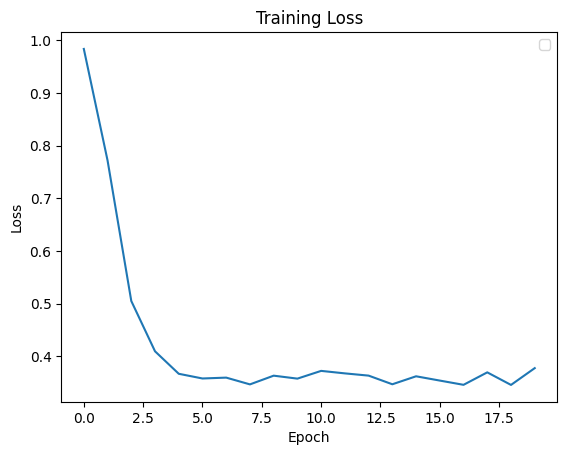

In [16]:
plt.plot(history["train_loss"])
plt.plot(history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")



plt.show()

## III. Embedding Visualisation

In [17]:
X = model.X
U = model.U
V = model.V
d = model.d_long

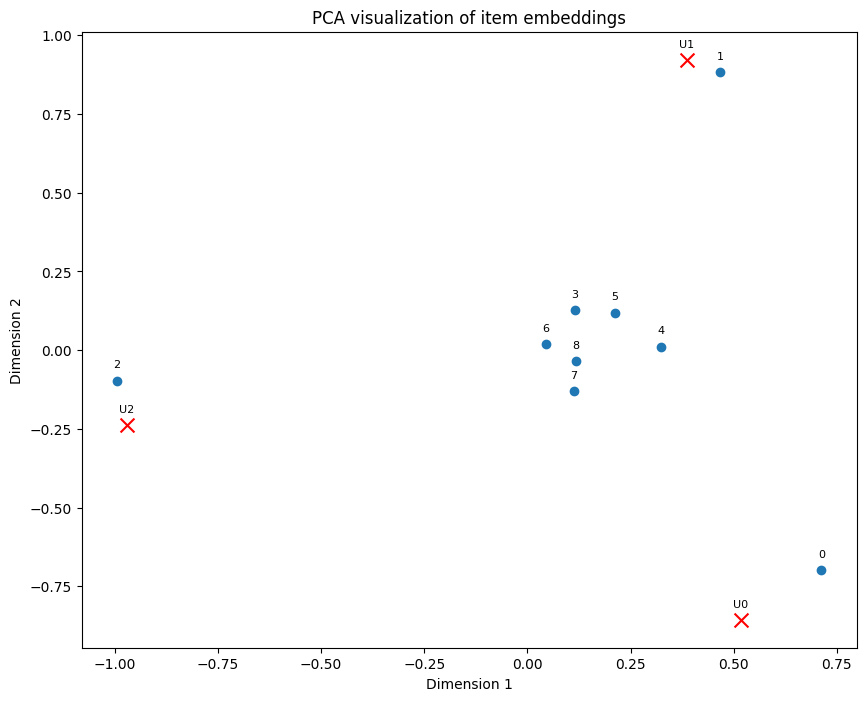

<Axes: >

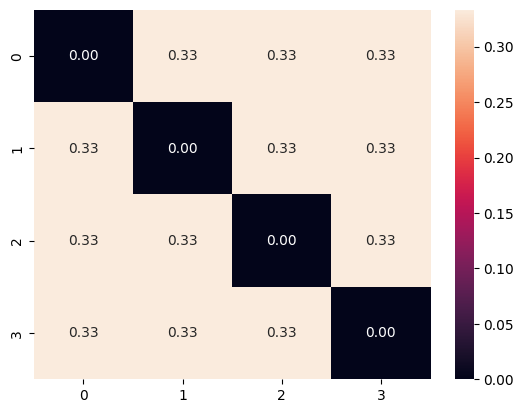

In [19]:
from sklearn.decomposition import PCA
import seaborn as sns

embedding = model.V
basket_batch = [[0,1,3,7]]
m_batch, affinity_matrix = model.embed_context(basket_batch, is_training=False)


if d ==1:
    embedding = np.hstack([embedding, np.zeros((embedding.shape[0],1))])
    U = tf.concat([U, tf.zeros((U.shape[0],1))], axis=1)

if d > 2:
    pca = PCA(n_components=2)
    V_pca = pca.fit_transform(embedding)
    U_pca = pca.transform(U.numpy())
else:
    V_pca = embedding
    U_pca = U.numpy()
plt.figure(figsize=(10, 8))
plt.scatter(V_pca[:, 0], V_pca[:, 1])#, c=color_group)

plt.scatter(U_pca[:,0], U_pca[:,1], color='red', marker='x', s=100, label='User 0')

for i in range(V_pca.shape[0]):
    plt.annotate(str(i), (V_pca[i, 0], V_pca[i, 1]+0.05), 
                     fontsize=8, ha='center', va='center')
for i in range(U_pca.shape[0]):
    plt.annotate(f'U{i}', (U_pca[i, 0], U_pca[i, 1]+0.05), 
                     fontsize=8, ha='center', va='center')

plt.title("PCA visualization of item embeddings")
plt.axis()
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


sns.heatmap(affinity_matrix[0],
            annot=True,     
            fmt='.2f',
            ) 

